<a href="https://colab.research.google.com/github/nekita473/Tech5_test_task/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, files):
        super().__init__()
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)
        
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [3]:
DIR = Path('./data')
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
files = list(DIR.rglob('*i(*'))

In [5]:
RESCALE_SIZE = 100
batch_size = 100

In [6]:
train_files, val_files = train_test_split(files, test_size=0.15)

In [7]:
train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class ConvNet(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 1 * 1, 2)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [10]:
def train(epochs, train_dataloader, val_dataloader, device, optimizer, loss_fn, model):
    train_loss = []
    val_loss = []
    accuracy = []
    for epoch in tqdm(range(epochs)):
        train_epoch_losses = []
        val_epoch_losses = []
        accuracy_epoch = []

        model.train()
        for pictures, labels in tqdm(train_dataloader):
            pictures, labels = pictures.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(pictures)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            train_epoch_losses.append(loss.item())
        train_loss.append(np.mean(train_epoch_losses))   

        model.eval()
        for pictures, labels in tqdm(val_dataloader):
            pictures, labels = pictures.to(device), labels.to(device)
            preds = model(pictures)
            loss = loss_fn(preds, labels)
            val_epoch_losses.append(loss.item())
            accuracy_epoch.append((torch.argmax(preds, dim=1) == labels).sum().item() / labels.shape[0])
        accuracy.append(np.mean(accuracy_epoch))
        val_loss.append(np.mean(val_epoch_losses))
        
        print('Train loss: ', train_loss[-1], 'Val loss: ', val_loss[-1], 'Accuracy: ', accuracy[-1])
    
    return train_loss, val_loss, accuracy

In [11]:
model = ConvNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3*1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 12

In [12]:
train_loss, val_loss, accuracy = train(epochs, train_dataloader, val_dataloader, device, optimizer, loss_fn, model)


Train loss:  0.682299398458921 Val loss:  0.6414226770401001 Accuracy:  0.7248936170212765



Train loss:  0.5477485335790194 Val loss:  0.4294402003288269 Accuracy:  0.796936170212766



Train loss:  0.4520868303684088 Val loss:  0.38565586805343627 Accuracy:  0.8237021276595744



Train loss:  0.42592977101986224 Val loss:  0.3769126355648041 Accuracy:  0.828936170212766



Train loss:  0.39177598976171935 Val loss:  0.33121654987335203 Accuracy:  0.858212765957447



Train loss:  0.3568485195820148 Val loss:  0.3243926763534546 Accuracy:  0.8434468085106384



Train loss:  0.33020966671980345 Val loss:  0.28878348469734194 Accuracy:  0.8637021276595744



Train loss:  0.30794554776870287 Val loss:  0.25374198853969576 Accuracy:  0.8947234042553192



Train loss:  0.3012300798526177 Val loss:  0.2435954362154007 Accuracy:  0.9134893617021277



Train loss:  0.26853376970841336 Val loss:  0.22208266854286193 Accuracy:  0.9169787234042553



Train loss:  0.2649383436028774 Val loss:  0.22512734234333037 Accuracy:  0.898468085106383



Train loss:  0.24212159159091803 Val loss:  0.20348635017871858 Accuracy:  0.9314893617021276



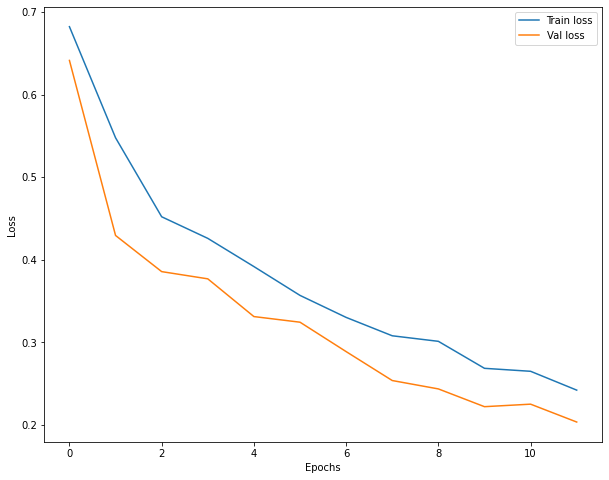

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

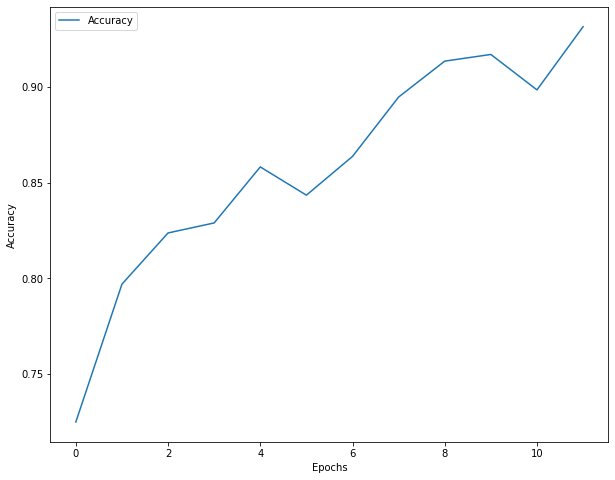

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


FOLD 1



Train loss:  0.6752495765686035 Val loss:  0.6448521216710409 Accuracy:  0.6980555555555555



Train loss:  0.5645136100550493 Val loss:  0.4792906492948532 Accuracy:  0.803125



Train loss:  0.4540363090733687 Val loss:  0.43312398592631024 Accuracy:  0.808125



Train loss:  0.41473452125986415 Val loss:  0.4000587463378906 Accuracy:  0.8116666666666665



Train loss:  0.38533465191721916 Val loss:  0.39820095400015515 Accuracy:  0.8165277777777779



Train loss:  0.36352304245034855 Val loss:  0.3565096954504649 Accuracy:  0.8301388888888889



Train loss:  0.33839499702056247 Val loss:  0.36097553620735806 Accuracy:  0.8424305555555555



Train loss:  0.3486229193707307 Val loss:  0.32081805169582367 Accuracy:  0.856875



Train loss:  0.3052086749424537 Val loss:  0.3072708323597908 Accuracy:  0.8770833333333333



Train loss:  0.2847658966978391 Val loss:  0.2801532248655955 Accuracy:  0.8838194444444446



Train loss:  0.2641208252559106 Val loss:  0.2601623311638832 Accuracy:  0.8890277777777779



Train loss:  0.247758395348986 Val loss:  0.2877129043142001 Accuracy:  0.8802083333333334



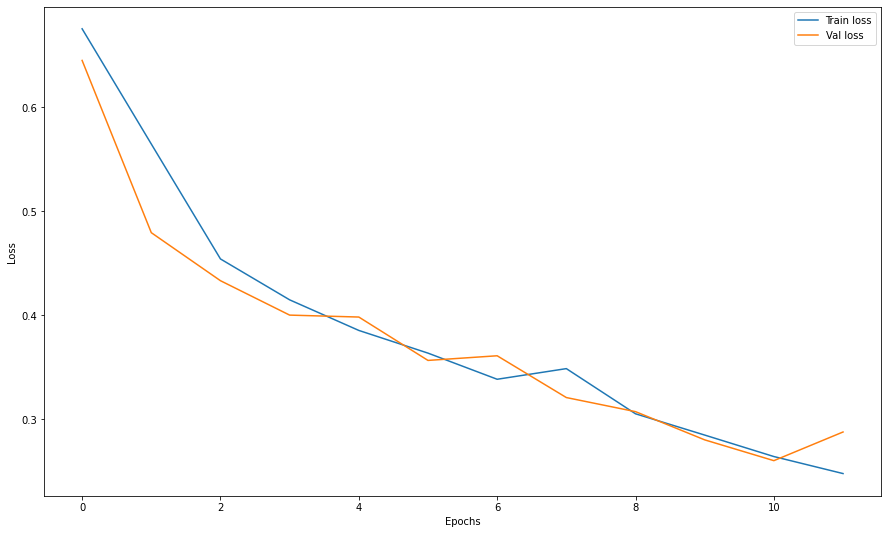


FOLD 2



Train loss:  0.677921029428641 Val loss:  0.6390957136948904 Accuracy:  0.7013157894736842



Train loss:  0.5884662469228109 Val loss:  0.4814769426981608 Accuracy:  0.8211403508771928



Train loss:  0.4769895983239015 Val loss:  0.4842603902022044 Accuracy:  0.7199122807017543



Train loss:  0.4306007884442806 Val loss:  0.38727230827013653 Accuracy:  0.8328070175438596



Train loss:  0.38970837121208507 Val loss:  0.3582547853390376 Accuracy:  0.8410526315789474



Train loss:  0.3619351461529732 Val loss:  0.36012598872184753 Accuracy:  0.8234210526315789



Train loss:  0.34426892300446826 Val loss:  0.3149529919028282 Accuracy:  0.8592982456140351



Train loss:  0.31661543312172097 Val loss:  0.28723694880803424 Accuracy:  0.8596491228070176



Train loss:  0.28151230824490386 Val loss:  0.2675387014945348 Accuracy:  0.8904385964912281



Train loss:  0.25919338688254356 Val loss:  0.257644126812617 Accuracy:  0.8925438596491229



Train loss:  0.24510231552024683 Val loss:  0.22980227073033652 Accuracy:  0.9090350877192982



Train loss:  0.24283157351116338 Val loss:  0.22656866535544395 Accuracy:  0.9070175438596492



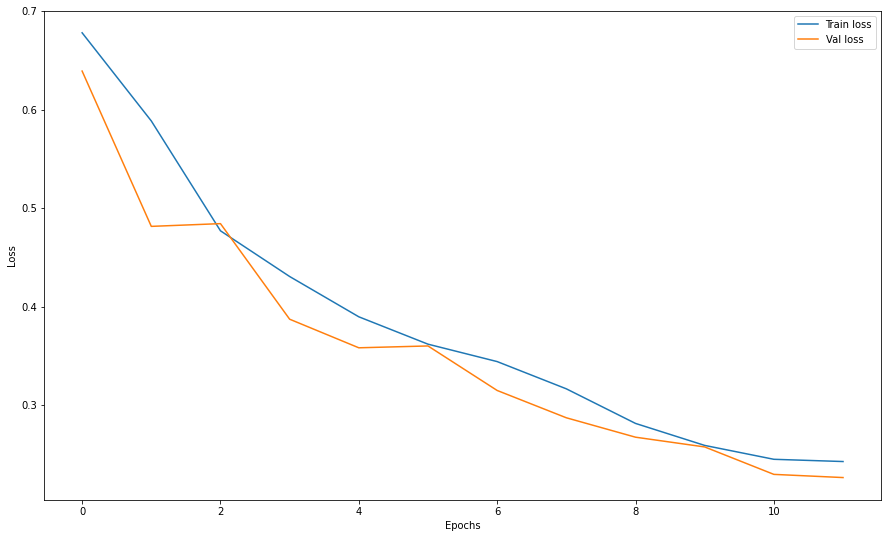


FOLD 3



Train loss:  0.6902122075359026 Val loss:  0.6835980117321014 Accuracy:  0.48



Train loss:  0.6264020030697187 Val loss:  0.5346223562955856 Accuracy:  0.7907894736842107



Train loss:  0.4405200369656086 Val loss:  0.43747295439243317 Accuracy:  0.7835964912280703



Train loss:  0.41926224281390506 Val loss:  0.4039497723182042 Accuracy:  0.8240350877192982



Train loss:  0.3595559547344844 Val loss:  0.38219958047072095 Accuracy:  0.8337719298245615



Train loss:  0.3529262722780307 Val loss:  0.3681841144959132 Accuracy:  0.8383333333333334



Train loss:  0.3195264668514331 Val loss:  0.3460566997528076 Accuracy:  0.8623684210526316



Train loss:  0.3145528007298708 Val loss:  0.35612991203864414 Accuracy:  0.8449999999999999



Train loss:  0.2874686798701684 Val loss:  0.31455568720897037 Accuracy:  0.8791228070175438



Train loss:  0.26434201188385487 Val loss:  0.30102090289195377 Accuracy:  0.8891228070175439



Train loss:  0.23651306920995316 Val loss:  0.30880166093508404 Accuracy:  0.8821052631578947



Train loss:  0.22242915506164232 Val loss:  0.34549709657828015 Accuracy:  0.8735087719298246



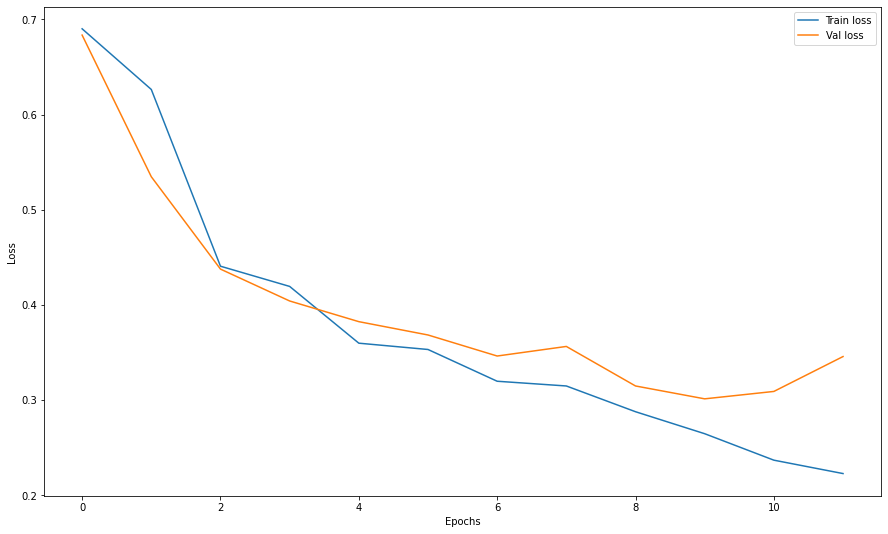


FOLD 4



Train loss:  0.6859491889675459 Val loss:  0.670998344818751 Accuracy:  0.5893859649122807



Train loss:  0.6136697977781296 Val loss:  0.5205096254746119 Accuracy:  0.7951754385964912



Train loss:  0.45127937694390613 Val loss:  0.42220228413740796 Accuracy:  0.8087719298245615



Train loss:  0.40251172333955765 Val loss:  0.4362835039695104 Accuracy:  0.792719298245614



Train loss:  0.3607949713865916 Val loss:  0.3718473861614863 Accuracy:  0.8424561403508771



Train loss:  0.3320416050652663 Val loss:  0.3391464551289876 Accuracy:  0.8721052631578946



Train loss:  0.3253508148094018 Val loss:  0.31959572434425354 Accuracy:  0.8721929824561404



Train loss:  0.3315597226222356 Val loss:  0.32112141450246173 Accuracy:  0.8608771929824561



Train loss:  0.2877351163576047 Val loss:  0.30238620191812515 Accuracy:  0.8821052631578947



Train loss:  0.27430596326788265 Val loss:  0.2844275583823522 Accuracy:  0.8839473684210528



Train loss:  0.25567286275327206 Val loss:  0.29452073325713474 Accuracy:  0.8887719298245615



Train loss:  0.26465709259112674 Val loss:  0.28155231724182767 Accuracy:  0.8659649122807016



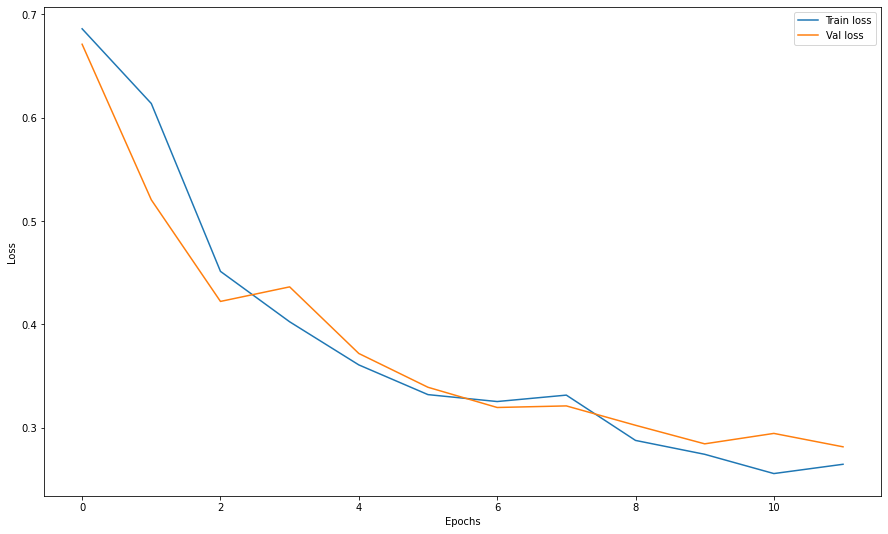


FOLD 5



Train loss:  0.6730397765835127 Val loss:  0.6227296441793442 Accuracy:  0.6952631578947369



Train loss:  0.5407954342663288 Val loss:  0.5225154682993889 Accuracy:  0.7748245614035089



Train loss:  0.46024954815705615 Val loss:  0.416723037759463 Accuracy:  0.8410526315789474



Train loss:  0.39341770360867184 Val loss:  0.3549427439769109 Accuracy:  0.8443859649122807



Train loss:  0.3398470381895701 Val loss:  0.29918109873930615 Accuracy:  0.859561403508772



Train loss:  0.2927143486837546 Val loss:  0.29074132194121677 Accuracy:  0.8962280701754386



Train loss:  0.28286472025016945 Val loss:  0.24065721035003662 Accuracy:  0.9093859649122806



Train loss:  0.252517506480217 Val loss:  0.23209418108065924 Accuracy:  0.9089473684210526



Train loss:  0.25425881954530877 Val loss:  0.21763858199119568 Accuracy:  0.9295614035087719



Train loss:  0.22438741413255534 Val loss:  0.2175432691971461 Accuracy:  0.8971052631578947



Train loss:  0.21622508578002453 Val loss:  0.20715926960110664 Accuracy:  0.9260526315789473



Train loss:  0.20795895314464966 Val loss:  0.2032520274321238 Accuracy:  0.9447368421052632



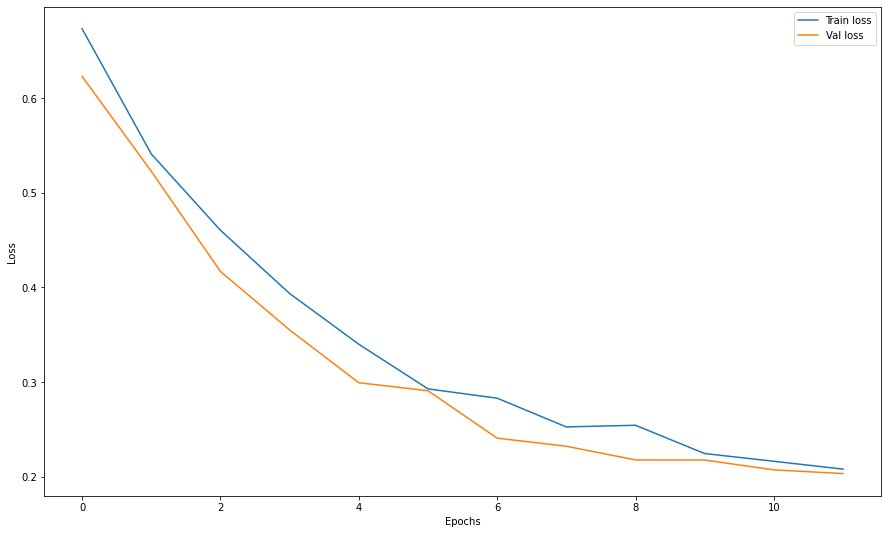

In [15]:
from sklearn.model_selection import StratifiedKFold
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
_ = [0]*len(files)
accuracies = []
for fold, (train_idx, val_idx) in enumerate(skf.split(files, _)):
    print('\nFOLD', fold+1)
    train_dataset = CustomDataset(np.array(files)[train_idx])
    val_dataset = CustomDataset(np.array(files)[val_idx])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ConvNet().to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=3*1e-4)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    train_loss, val_loss, val_acc = train(epochs, train_dataloader, val_dataloader, device, optimizer, loss_fn, model)
    plt.figure(figsize=(15, 9))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Val loss")
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    plt.close()

    accuracies.append(val_acc)

In [20]:
np.mean(np.array(accuracies)[:, -1])

0.8942872807017543